**Importing all our reequired libraries**

In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')

**Loading the data from tfds**

In [2]:
datasets, info = tfds.load(name = 'patch_camelyon', with_info= True, split=['train', 'test', 'validation'], as_supervised= True)

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteU1YFEM/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteU1YFEM/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteU1YFEM/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


**Check out what our data holds**

In [3]:
info

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

**Create the training data**

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


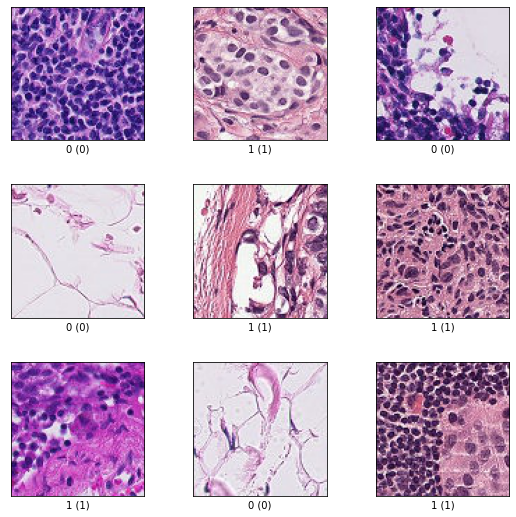

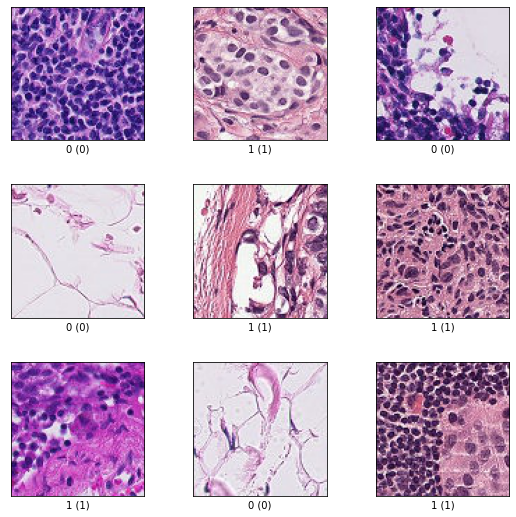

In [4]:
train, info_train = tfds.load(name = 'patch_camelyon', with_info= True, split= 'test')
tfds.show_examples(info_train, train)

**Create a function to scale the images in our data**

In [6]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return tf.image.resize(image, [224, 224]), tf.one_hot(label, 2)

**Create a function to get data in batches of 32**

In [7]:
def get_dataset(batch_size = 32):
  train_scaled = datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_scaled = datasets[1].map(scale).batch(batch_size)
  val_scaled = datasets[2].map(scale).batch(batch_size)
  return train_scaled, test_scaled, val_scaled

**Put the training and validation data in cache memory**

In [8]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

**Now, we use the Mobile Net model of Tensorflow Hub as our feature extractor**

In [10]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

**We give the input shape as 224x224x3 as that is the size accepted by Mobile Net**

In [11]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape = (224, 224, 3))

In [12]:
feature_extractor_layer.trainable = False

**Creating the Sequential model with our data**

In [16]:
model = tf.keras.Sequential([feature_extractor_layer, tf.keras.layers.Dropout(0.3), tf.keras.layers.Dense(2, activation = 'softmax')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


**Compiling the model**

In [17]:
model.compile(optimizer= tf.keras.optimizers.Adam(), loss= tf.keras.losses.CategoricalCrossentropy(from_logits= True), metrics = ['acc'])

**Fitting the model**

In [19]:
history = model.fit(train_dataset, epochs= 5, validation_data= val_dataset)

Epoch 1/5
8192/8192 [==============================] - 556s 68ms/step - loss: 0.3630 - acc: 0.8414 - val_loss: 0.3771 - val_acc: 0.8276
Epoch 2/5
8192/8192 [==============================] - 550s 67ms/step - loss: 0.3637 - acc: 0.8418 - val_loss: 0.3995 - val_acc: 0.8203
Epoch 3/5
8192/8192 [==============================] - 545s 66ms/step - loss: 0.3637 - acc: 0.8414 - val_loss: 0.4195 - val_acc: 0.8080
Epoch 4/5
8192/8192 [==============================] - 552s 66ms/step - loss: 0.3632 - acc: 0.8414 - val_loss: 0.4115 - val_acc: 0.8084
Epoch 5/5
8192/8192 [==============================] - 546s 66ms/step - loss: 0.3620 - acc: 0.8422 - val_loss: 0.3803 - val_acc: 0.8269


**Checking the performance using a simple plot**

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

**Getting visuals of Losses and Accuracies**

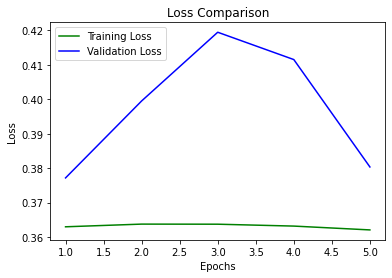

In [21]:
eps = range(1, 6)
plt.plot(eps, train_loss, 'g', label = 'Training Loss')
plt.plot(eps, val_loss,'b', label = 'Validation Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

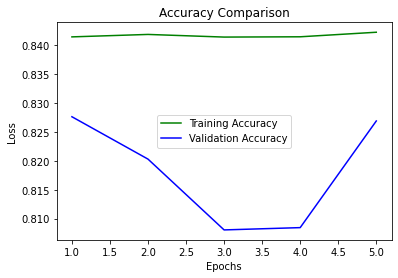

In [22]:
eps = range(1, 6)
plt.plot(eps, train_acc, 'g', label = 'Training Accuracy')
plt.plot(eps, val_acc,'b', label = 'Validation Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluate the model's performance on the test data**

In [23]:
result = model.evaluate(test_dataset)

1024/1024 [==============================] - 47s 44ms/step - loss: 0.4128 - acc: 0.8156


**Create a function to predict the labels for scaled images and show the differences along with the image**

[[0.69646513 0.30353484]]


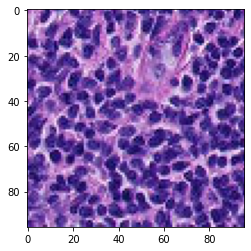

Actual Label: 0
Predicted Label: 0
[[0.02879832 0.9712017 ]]


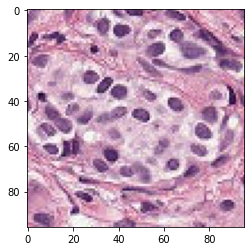

Actual Label: 1
Predicted Label: 1
[[0.99449664 0.00550342]]


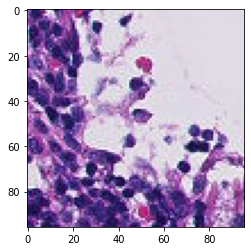

Actual Label: 0
Predicted Label: 0
[[0.9972588  0.00274121]]


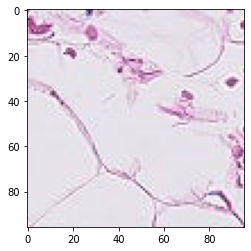

Actual Label: 0
Predicted Label: 0
[[0.39185762 0.6081424 ]]


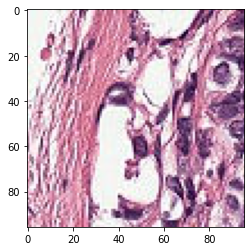

Actual Label: 1
Predicted Label: 1
[[0.6083267 0.3916733]]


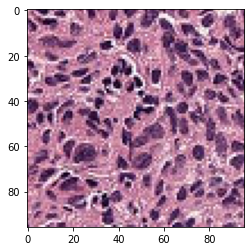

Actual Label: 1
Predicted Label: 0
[[0.4442026 0.5557974]]


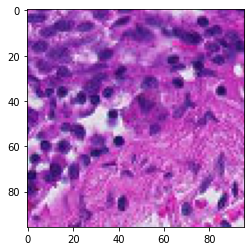

Actual Label: 1
Predicted Label: 1
[[0.9725177  0.02748229]]


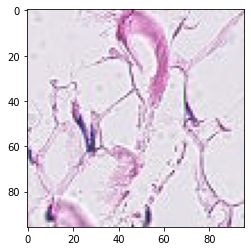

Actual Label: 0
Predicted Label: 0
[[0.12449509 0.8755049 ]]


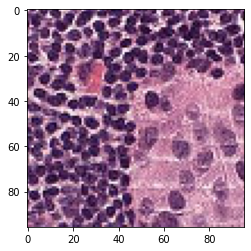

Actual Label: 1
Predicted Label: 1
[[0.00324405 0.9967559 ]]


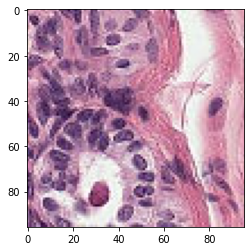

Actual Label: 1
Predicted Label: 1


In [24]:
for test_sample in datasets[1].take(10):
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr = scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis = 0)

  img = tf.keras.preprocessing.image.img_to_array(image)
  pred = model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features['label'].names[label.numpy()])
  print("Predicted Label: %s" % info.features['label'].names[np.argmax(pred)])

**Creating the confusion matrix for the predictions**

In [25]:
for f0, f1 in datasets[1].map(scale).batch(200):
  y = np.argmax(f1, axis= 1)
  y_pred = np.argmax(model.predict(f0), axis= 1)
  print("The Confusion Matrix is as shown: \n",tf.math.confusion_matrix(labels= y, predictions= y_pred, num_classes= 2))

The Confusion Matrix is as shown: 
 tf.Tensor(
[[84 17]
 [22 77]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[78 24]
 [21 77]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[87 17]
 [15 81]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[100  14]
 [ 17  69]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[86 22]
 [22 70]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[88 13]
 [28 71]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[83 12]
 [22 83]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[77 18]
 [20 85]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[88 14]
 [33 65]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[79 17]
 [19 85]], shape=(2, 2), dtype=int32)
The Confusion Matrix is as shown: 
 tf.Tensor(
[[85 16]
